# Allstate analysis

Author: Mo Al Elew

**What notebook does/produces:**

Replicates and fact checks all the data findings used in publication

**Approach:**

The general pattern includes:
1. Quote the relevant text
2. Determine asserted figure to reproduce
3. Run the operations to reproduce relevant figure
4. Assert expected value against actual value
5. Print the relevant text with the actual value templated in

Some findings cannot be directly tested using an assertion against a single value. In those cases, I display the relevant data slice, chart, or other presentation.

In [1]:
import math

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

# Constants and helper functions

In [2]:
INSURER = "Allstate"
DATA_FP = "./outputs/allstate_auto_gis.geojson"

ZCTA_GIS_FP = "../01_demographics/outputs/zcta_demographics_map.geojson"
TRACT_GIS_FP = "../01_demographics/outputs/tract_demographics_map.geojson"

RATE_TABLE_FP = "./outputs/allstate_auto.csv"
COLS_TO_READ = [
    "company",
    "vehicle_type",
    "geography_type",
    "geography_factor_id",
    "latitude",
    "longitude",
    "generic_location_based_premium",
]

PREREFORM_DATA_FP = "../09_pre_reform/allstate/outputs/allstate_auto_gis.geojson"

In [3]:
PROJECTED_CRS = "EPSG:3078"
GEOGRAPHIC_CRS = "EPSG:3857"

In [4]:
RATE_Q_LABELS = [
    "lowest effect",
    "middle low",
    "median",
    "middle high",
    "highest effect",
]
INCOME_Q_LABELS = [
    "lowest income",
    "middle low",
    "median",
    "middle high",
    "highest income",
]

QUANTILE_ANALYSIS_COLS = [
    "geo_id",
    "geo_name",
    "total_pop",
    "white_tot",
    "black_tot",
    "generic_location_based_premium",
    "effect_quantile",
]

DENSITY_Q_LABELS = [
    "lowest density",
    "middle low",
    "median",
    "middle high",
    "highest density",
]

GEOID_GROUP_BY_COLS = [
    "generic_location_based_premium",
    "white_tot",
    "black_tot",
    "total_pop",
    "density",
    "median_income",
]

QUANTILE_GROUP_BY_COLS = ["black_tot", "white_tot", "total_pop"]

TRACT_COLS = [
    "geo_id",
    "geo_name",
    "total_pop",
    "geometry",
]
RATE_EFFECT_COLUMNS = [
    "generic_location_based_premium",
    "location_effect",
    "geometry",
]

In [5]:
%run ../00_misc/helper-func-notebook.ipynb

In [6]:
def round_half_up(n, decimals=0):
    multiplier = 10**decimals
    return math.floor(n * multiplier + 0.5) / multiplier


def prptn_to_pct(val, precision=3):
    return round(val, precision) * 100


# adaptted from: https://stackabuse.com/calculating-spearmans-rank-correlation-coefficient-in-python-with-pandas/
def display_correlation(df, method="pearson"):
    r = df.corr(method=method)
    plt.figure(figsize=(10, 6))
    heatmap = sns.heatmap(r, vmin=-1, vmax=1, annot=True)
    plt.title(f"{method} correlation")
    return r


def plot_data_corr(df, title, color="green"):
    r = display_correlation(df)
    fig, ax = plt.subplots(nrows=1, ncols=len(df.columns) - 1, figsize=(14, 3))
    for i in range(1, len(df.columns)):
        ax[i - 1].scatter(df["X"], df.values[:, i], color=color)
        ax[i - 1].title.set_text(title[i] + "\n r = " + "{:.2f}".format(r.values[0, i]))
        ax[i - 1].set(xlabel=df.columns[0], ylabel=df.columns[i])
    fig.subplots_adjust(wspace=0.7)
    plt.show()


def google_maps_lat_lon(latitude, longitude, zoom_level=12):
    return (
        f"https://maps.google.com/maps?z={zoom_level}&t=m&q=loc:{latitude}+{longitude}"
    )


def google_maps_coords(coords_shapely):
    return google_maps_lat_lon(coords_shapely.y, coords_shapely.x)

In [7]:
NEAREST_NEIGHBOR_COUNT = 8


def n_nearest_neighbors(df, n_neighbors):
    # 2d numpy array of the coordinates
    coords = np.array(df.geometry.map(lambda p: [p.x, p.y]).tolist())

    # "train"/initialize the NearestNeighbors model
    # NOTE: N_NEIGHBORS + 1 since we are dropping the nearest point
    #       (which is each point itself with distance 0)
    knn = NearestNeighbors(n_neighbors=n_neighbors + 1, algorithm="kd_tree").fit(coords)
    # retrieve neighbors (distance and index)
    knn_dist, knn_idx = knn.kneighbors(coords)

    # add results to dataframe:
    df[list(map("NEIGHBOR_{}".format, range(1, n_neighbors + 1)))] = (
        df.geometry.values.to_numpy()[knn_idx[:, 1:]]
    )
    rate_cols = list(map("NEIGHBOR_RATE_{}".format, range(1, n_neighbors + 1)))
    df[rate_cols] = df["generic_location_based_premium"].to_numpy()[knn_idx[:, 1:]]

    geo_id_cols = list(map("NEIGHBOR_GEO_ID_{}".format, range(1, n_neighbors + 1)))
    neighbor_geo_id = df["geo_id"].to_numpy()[knn_idx[:, 1:]]
    df["neighbors_geo_id"] = [set(i) for i in neighbor_geo_id]

    for idx, col in enumerate(rate_cols):
        df[f"NEIGHBOR_DIV_{idx+1}"] = df["generic_location_based_premium"] / df[col]

# Read data

In [8]:
GDF_CLEAN_DATA = gpd.read_file("./outputs/allstate_auto_clean.geojson")

# Preprocess

Points falling outside a ZCTA largely fell within nature preservers or parks

In [9]:
is_outside_zip_bounds = GDF_CLEAN_DATA["geo_id"].isna()
print(f"Dropping {is_outside_zip_bounds.sum()} points")

gdf = GDF_CLEAN_DATA[~is_outside_zip_bounds].copy()
gdf["white_pct"] = gdf["white_pct"].astype(float)
gdf["black_pct"] = gdf["black_pct"].astype(float)
gdf["median_income"] = gdf["median_income"].astype(float)

Dropping 1052 points


In [10]:
assert (gdf["white_pct"] > 1).any()
gdf["is_maj_white"] = gdf["white_pct"] > 49
gdf["is_maj_black"] = gdf["black_pct"] > 49

In [11]:
state_median_rate = gdf["generic_location_based_premium"].median()
state_median_rate

6955.52

# Topline

## Gridded plane size

> Allstate divided Michigan into a grid of 78,015 territories for its location-fixed base rates.

In [12]:
GRID_SIZE_ASSERTION = 78015
GDF_DATA = gpd.read_file(DATA_FP)
GDF_DATA = GDF_DATA.dropna(how="all", axis=1)
grid_count = GDF_DATA["geography_factor_id"].nunique()
assert GRID_SIZE_ASSERTION == grid_count
print(
    f"Allstate divided the state into a gridded plane with {grid_count} units for its geography-based base rates and factors."
)
del GDF_DATA

Allstate divided the state into a gridded plane with 78015 units for its geography-based base rates and factors.


## Geography match experiment

> To determine the best fit for matching demographic data on race and income, we merged each territory to the block, block group, ZCTA, census tract, and county it fell within. Blocks and block groups left over 80 percent of the state’s population without an Allstate insurance territory. Tracts left 10 percent of the population without a territory match. ZCTAs minimized the internal variation of location-adjusted base rates without removing a single populated area without a gridded rate point that did not contain an Allstate territory. Therefore, we matched Allstate’s territories to 2022 ACS demographic data by ZCTA.

I rerun the experiment code for ZCTA. The other experiments can be reviewed in `00b_geography_experiment`

In [13]:
DF_GRID = pd.read_csv(RATE_TABLE_FP, usecols=COLS_TO_READ)

GDF_ZCTA = gpd.read_file(ZCTA_GIS_FP)
GDF_ZCTA = GDF_ZCTA[GDF_ZCTA["total_pop"] > 0]

gdf_rate_table = gpd.GeoDataFrame(
    DF_GRID,
    geometry=gpd.points_from_xy(DF_GRID["longitude"], DF_GRID["latitude"]),
)

In [14]:
gdf_rate_table_zcta = gdf_rate_table.sjoin(
    GDF_ZCTA, how="inner", predicate="intersects"
)

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:2195: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


In [15]:
def generate_report(gdf_geo_merged, geography="geographic unit", groupby="geo_id"):
    geography_count = gdf_geo_merged["geo_id"].nunique()
    gdf_point_summary = gdf_geo_merged.groupby(groupby)[
        "generic_location_based_premium"
    ].describe()
    gdf_point_summary["var"] = round(
        gdf_geo_merged.groupby(groupby)["generic_location_based_premium"].var()
    )
    gdf_point_summary["range"] = gdf_point_summary["max"] - gdf_point_summary["min"]

    avg_count = round(gdf_point_summary["count"].mean())
    med_count = round(gdf_point_summary["count"].median())
    value_count = gdf_point_summary["count"].value_counts()
    single_point_tract_pct = (
        round(value_count[1] / len(gdf_point_summary.index), 3) * 100
    )

    largest_intra_unit_range = gdf_point_summary[
        gdf_point_summary["range"] == gdf_point_summary["range"].max()
    ].iloc[0]
    largest_intra_unit_range_val = gdf_point_summary["range"].max()
    largest_intra_unit_range_count = largest_intra_unit_range["count"]
    largest_intra_unit_range_name = largest_intra_unit_range.name

    largest_intra_unit_var = gdf_point_summary[
        gdf_point_summary["var"] == gdf_point_summary["var"].max()
    ].iloc[0]
    largest_intra_unit_var_val = gdf_point_summary["var"].max()
    largest_intra_unit_var_count = largest_intra_unit_var["count"]
    largest_intra_unit_var_name = largest_intra_unit_var.name

    print(f"There are {geography_count} {geography}s.\n")
    print(f"{single_point_tract_pct}% of {geography}s contain a single gridded unit.\n")
    print(
        f"The range of units within {geography} is {gdf_point_summary['count'].min()} to {gdf_point_summary['count'].max()}.\n"
    )
    print(f"On average, there is {avg_count} points within a {geography}.\n")
    print(f"The median {geography} has {med_count} gridded units in it.\n")
    print(
        f"The largest location rate range within a single {geography} is {largest_intra_unit_range_val} among {largest_intra_unit_range_count} units in {largest_intra_unit_range_name}.\n"
    )
    print(
        f"The largest location rate variance within a single {geography} is {largest_intra_unit_var_val} among {largest_intra_unit_var_count} units in {largest_intra_unit_var_name}.\n"
    )
    return gdf_point_summary


zcta_summary = generate_report(gdf_rate_table_zcta, "zcta")
zcta_summary

There are 962 zctas.

3.4000000000000004% of zctas contain a single gridded unit.

The range of units within zcta is 1.0 to 980.0.

On average, there is 80 points within a zcta.

The median zcta has 53 gridded units in it.

The largest location rate range within a single zcta is 6704.759999999999 among 92.0 units in 860Z200US48111.

The largest location rate variance within a single zcta is 3025803.0 among 38.0 units in 860Z200US48164.



,count,mean,std,min,25%,50%,75%,max,var,range
geo_id,,,,,,,,,,
860Z200US48001,34.0,9822.955294,343.541697,9151.86,9905.110,10012.12,10012.12,10012.12,118021.0,860.26
860Z200US48002,48.0,10388.173750,62.322931,10195.22,10331.025,10423.62,10423.62,10423.62,3884.0,228.40
860Z200US48003,46.0,10800.354783,172.264460,10270.14,10782.575,10888.74,10888.74,10926.26,29675.0,656.12
860Z200US48005,48.0,10440.588333,99.344751,10132.12,10462.520,10482.34,10482.34,10482.34,9869.0,350.22
860Z200US48006,91.0,10241.176484,64.962782,9814.08,10262.700,10262.70,10262.70,10262.70,4220.0,448.62
...,...,...,...,...,...,...,...,...,...,...
860Z200US49968,359.0,7900.201170,28.349048,7529.32,7899.280,7899.28,7899.28,8221.02,804.0,691.70
860Z200US49969,393.0,8593.669415,22.706648,8420.26,8594.520,8594.52,8594.52,8660.22,516.0,239.96
860Z200US49970,122.0,7020.180656,550.608527,6112.84,6265.930,7375.84,7375.84,7417.90,303170.0,1305.06


# Prereform

> Before the 2019 reform that prohibited the practice, Allstate divided Michigan by zip code in its location-fixed base rates. Pre-reform, about one in four residents lived in the top quintile. This included 67 percent of Black Michiganders and 19 percent of White Michiganders.

In [16]:
GDF_PREREFORM_DATA = gpd.read_file(PREREFORM_DATA_FP)
geographic_crs = GDF_PREREFORM_DATA.crs
GDF_PREREFORM_DATA["density"] = (
    GDF_PREREFORM_DATA["tot_pop"] / GDF_PREREFORM_DATA.to_crs(PROJECTED_CRS).area
)
zcta_len = int(GDF_PREREFORM_DATA["geo_id"].str.len()[0])

In [17]:
GDF_PREREFORM_DATA["effect_quantile"] = pd.qcut(
    GDF_PREREFORM_DATA["generic_location_based_premium"],
    q=len(RATE_Q_LABELS),
    labels=RATE_Q_LABELS,
)
gdf_groupby_quantiles = GDF_PREREFORM_DATA.groupby("effect_quantile", observed=False)[
    ["black_tot", "white_tot", "tot_pop"]
].sum()

df_pre_reform_distribution = prptn_to_pct(
    gdf_groupby_quantiles.div(gdf_groupby_quantiles.sum(axis=0), axis=1)
)
df_pre_reform_distribution

,black_tot,white_tot,tot_pop
effect_quantile,,,
lowest effect,9.3,24.8,22.6
middle low,9.2,17.4,16.4
median,3.6,12.3,10.8
middle high,11.5,27.1,24.5
highest effect,66.5,18.5,25.8


In [18]:
ASSERTED_TOTAL_POP_PCT_MIN_RANGE = 24
ASSERTED_TOTAL_POP_PCT_MAX_RANGE = 27
ASSERTED_BLACK_POP_PCT = 67
ASSERTED_WHITE_POP_PCT = 19

highest_effect_pop_ceil = (df_pre_reform_distribution.loc["highest effect"]).apply(
    round_half_up
)
assert (
    ASSERTED_TOTAL_POP_PCT_MIN_RANGE < highest_effect_pop_ceil["tot_pop"]
    and ASSERTED_TOTAL_POP_PCT_MAX_RANGE > highest_effect_pop_ceil["tot_pop"]
)
assert ASSERTED_BLACK_POP_PCT == highest_effect_pop_ceil["black_tot"]
assert ASSERTED_WHITE_POP_PCT == highest_effect_pop_ceil["white_tot"]

In [19]:
print(
    f"""Pre-reform, {highest_effect_pop_ceil["tot_pop"]} residents lived in the top quintile."""
)
print(
    f"""This included {highest_effect_pop_ceil["black_tot"]} percent of Black Michiganders and {highest_effect_pop_ceil["white_tot"]} percent of White Michiganders."""
)

Pre-reform, 26.0 residents lived in the top quintile.
This included 67.0 percent of Black Michiganders and 19.0 percent of White Michiganders.


# Majority Black ZCTAs

> After the reform, the median location effect for majority Black ZCTAs was 40 percent higher than the statewide median and within the top six percent of all territories. The median location effect in majority White ZCTAs was on par with the state median.

In [20]:
gdf_maj_black = gdf[gdf["is_maj_black"]]
maj_black_median_rate = gdf_maj_black["generic_location_based_premium"].median()
median_loc_effect_maj_black = gdf_maj_black[
    gdf_maj_black["generic_location_based_premium"] == maj_black_median_rate
]["location_effect"].iloc[0]
print(
    f"The state median rate is {state_median_rate} and the median rate in majority Black zip codes is {maj_black_median_rate}, so {state_median_rate} / {maj_black_median_rate}"
)
print(
    f"The median location effect for majority Black ZCTAs was {median_loc_effect_maj_black} times the statewide median"
)

The state median rate is 6955.52 and the median rate in majority Black zip codes is 9707.96, so 6955.52 / 9707.96
The median location effect for majority Black ZCTAs was 1.39 times the statewide median


In [21]:
percentile = percentile_of_score(
    maj_black_median_rate,
    gdf["generic_location_based_premium"],
)
top_pct = 100 - percentile
f"The median location effect for majority Black ZCTAs is in the top {top_pct}."

'The median location effect for majority Black ZCTAs is in the top 5.599999999999994.'

In [22]:
gdf_maj_white = gdf[gdf["is_maj_white"]]
maj_white_median_loc_effect = gdf_maj_white["location_effect"].median()
f"The median location effect in majority White ZCTAs is {maj_white_median_loc_effect}"

'The median location effect in majority White ZCTAs is 1.0'

# Rate quantiles

> Thirty-four percent of Michiganders lived in a ZCTA where the typical location effect was within the top quintile of the state. Sixty-nine percent of Black residents lived in that top quintile compared to 28 percent of White residents.

Since Allstate uses a gridded map, I attempt three different ways to analyze the quantiles by demographics.

1. I average the generic rate for each ZCTA `geo_id` 

I moved the these approaches to the [appendix below](#Different_quantile_approaches)

2. Drop all duplicate ZCTA `geo_id` entries within quantiles - this approach allows for the same ZCTA to appear in multiple quantiles
3. Drop all duplicate ZCTA `geo_id` entries in each quantile retaining the one in the lowest quantile

## Average rate

I average the rates by geographic id to avoid double counting 

In [23]:
gdf_groupby_geo_id = gdf.groupby("geo_id")[GEOID_GROUP_BY_COLS].mean()
gdf_groupby_geo_id["income_quantile"] = pd.qcut(
    gdf_groupby_geo_id["median_income"],
    q=len(INCOME_Q_LABELS),
    labels=INCOME_Q_LABELS,
)
gdf_groupby_geo_id["effect_quantile"] = pd.qcut(
    gdf_groupby_geo_id["generic_location_based_premium"],
    q=len(RATE_Q_LABELS),
    labels=RATE_Q_LABELS,
)
gdf_groupby_geo_id["effect_quantile"] = pd.qcut(
    gdf_groupby_geo_id["generic_location_based_premium"],
    q=len(RATE_Q_LABELS),
    labels=RATE_Q_LABELS,
)
gdf_groupby_geo_id["density_quantile"] = pd.qcut(
    gdf_groupby_geo_id["density"], q=len(DENSITY_Q_LABELS), labels=DENSITY_Q_LABELS
)

This calculates (subset in quantile / total in quantile)

For example: TK% of people living in a top quarter of rates are Black.

In [24]:
gdf_groupby_quantiles = gdf_groupby_geo_id.groupby("effect_quantile", observed=False)[
    QUANTILE_GROUP_BY_COLS
].sum()


print("This calculates (group subset in quantile / total group population)")
df_distribution = prptn_to_pct(
    gdf_groupby_quantiles.div(gdf_groupby_quantiles.sum(axis=0), axis=1)
)
df_distribution

This calculates (group subset in quantile / total group population)


,black_tot,white_tot,total_pop
effect_quantile,,,
lowest effect,8.0,20.8,19.0
middle low,4.6,14.4,12.8
median,8.6,16.3,15.3
middle high,9.9,20.1,18.4
highest effect,68.9,28.3,34.4


In [25]:
highest_quantile = round(df_distribution.loc["highest effect"])
print(
    f"""{highest_quantile["total_pop"]} percent of Michiganders lived in a ZCTA where the typical location effect was within the top quintile of the state. {highest_quantile["black_tot"]} percent of Black residents lived in that top quintile compared to {highest_quantile["white_tot"]} percent of White residents."""
)

34.0 percent of Michiganders lived in a ZCTA where the typical location effect was within the top quintile of the state. 69.0 percent of Black residents lived in that top quintile compared to 28.0 percent of White residents.


## Stacked chart

First draft of chart

In [26]:
%run ../00_misc/helper-func-notebook.ipynb
stacked_quintile_chart = stacked_race_hbar(df_distribution, "Allstate")
stacked_quintile_chart.save("../00_misc/charts/allstate_population_quintile.png")
stacked_quintile_chart

alt.Chart(...)

# Detroit

## Median

> The median location effect in Detroit, which is 76 percent Black, was more than double the statewide median.

[Detroit demographics source](https://censusreporter.org/profiles/16000US2622000-detroit-mi/)

<Axes: >

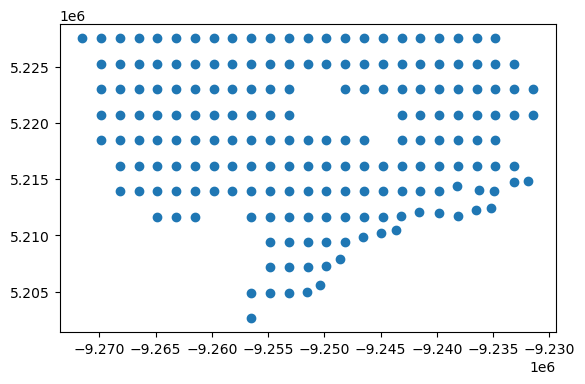

In [27]:
gdf_detroit = gdf[gdf["is_in_detroit"] & gdf["geo_id"].notnull()]
gdf_detroit.plot()

In [28]:
detroit_median_rate = gdf_detroit["generic_location_based_premium"].median()
detroit_median_div_state_median_rate = round(detroit_median_rate / state_median_rate, 2)
f"The median location effect in Detroit, which is 76 percent Black, was {detroit_median_div_state_median_rate} ({detroit_median_rate} / {state_median_rate}) times the statewide median."

'The median location effect in Detroit, which is 76 percent Black, was 2.56 (17784.42 / 6955.52) times the statewide median.'

## Minimum

> The lowest location effect within Detroit’s borders was higher than 99.4 percent of all other location zones in the state. Less than 1 percent of the state fell within the range of rates calculated for Detroit.

In [29]:
ASSERTED_PERCENTILE = 99.4
detroit_min_rate = gdf_detroit["generic_location_based_premium"].min()
percentile = percentile_of_score(
    detroit_min_rate, gdf["generic_location_based_premium"]
)
assert ASSERTED_PERCENTILE <= percentile
f"The lowest location effect within Detroit’s borders is higher than {percentile} percent of all other location zones in the state."

'The lowest location effect within Detroit’s borders is higher than 99.4 percent of all other location zones in the state.'

In [30]:
ASSERTED_PCT = 1
df_temp = gdf[
    ~gdf["is_in_detroit"] & (gdf["generic_location_based_premium"] >= detroit_min_rate)
]
grtr_than_detroit_min_unit_count = len(df_temp)
pct_grtr_than_detroit = round(grtr_than_detroit_min_unit_count / len(gdf), 3) * 100
assert ASSERTED_PCT > pct_grtr_than_detroit
f"{pct_grtr_than_detroit} percent of the state fall within the range of rates calculated for Detroit."

'0.3 percent of the state fall within the range of rates calculated for Detroit.'

# Statewide

## Maximum rate

> Allstate’s highest location-fixed base rates were for customers in Detroit’s Morningside neighborhood, where the location effect was more than triple the company’s statewide median.

In [31]:
ASSERTED_FIGURE = 3
max_rate = gdf["generic_location_based_premium"].max()
max_rate_div_median = round(max_rate / state_median_rate, 2)
assert ASSERTED_FIGURE < max_rate_div_median
f"""
Allstate’s highest location-fixed base rates were for customers in Detroit’s Morningside neighborhood,
where the location effect was {max_rate_div_median} ({max_rate}/{state_median_rate}) times the statewide median.
"""

'\nAllstate’s highest location-fixed base rates were for customers in Detroit’s Morningside neighborhood,\nwhere the location effect was 3.31 (23022.58/6955.52) times the statewide median.\n'

In [32]:
google_maps_coords(
    gdf[
        gdf["generic_location_based_premium"]
        == gdf["generic_location_based_premium"].max()
    ]
    .to_crs(geographic_crs)
    .iloc[0]["geometry"]
)

'https://maps.google.com/maps?z=12&t=m&q=loc:42.41250152210396+-82.94250939222181'

## Minimum rate

> Allstate’s lowest location-fixed base rates were near Mattawan, Mich., in an area spanning the 49009 and 49071 ZCTAs. The location effect there is 33 percent lower than than the statewide median.

In [33]:
ASSERTED_FIGURE = 33
min_rate = gdf["location_effect"].min()
gdf_temp = gdf[gdf["location_effect"] == gdf["location_effect"].min()]
min_effect_zctas = list(gdf_temp["geo_name"].unique())
pct_decrease = round(1 - min_rate, 2) * 100
assert ASSERTED_FIGURE == pct_decrease, min_rate
print(
    f"Allstate’s lowest location-fixed base rates were near Mattawan, Mich., in an area spanning the {min_effect_zctas} ZCTAs. The location effect there is {pct_decrease} percent lower than than the statewide median or {min_rate} times the statewide median."
)

Allstate’s lowest location-fixed base rates were near Mattawan, Mich., in an area spanning the ['ZCTA5 49071', 'ZCTA5 49009'] ZCTAs. The location effect there is 33.0 percent lower than than the statewide median or 0.67 times the statewide median.


In [34]:
google_maps_coords(
    gdf[
        gdf["generic_location_based_premium"]
        == gdf["generic_location_based_premium"].min()
    ]
    .to_crs(geographic_crs)
    .iloc[0]["geometry"]
)

'https://maps.google.com/maps?z=12&t=m&q=loc:42.27749979716688+-85.79250487611478'

# Nearest neighbor

> Performing a nearest neighbor analysis showed that, on average, Allstate set rates for a territory similar to those of its surrounding neighbors.

`loc_rate_div_min_nn` = $\frac{Location\ zone\ location\ set\ base\ rate}{min(Location\ set\ base\ rate\ adjacent\ zones)}$

In [35]:
avg_ratio_btwn_rate_and_nn_min = round(gdf["loc_rate_div_min_nn"].mean(), 2)
f"Performing a nearest neighbor analysis showed that, on average, Allstate set location zone rates {avg_ratio_btwn_rate_and_nn_min} times their surrounding zone neighbors."

'Performing a nearest neighbor analysis showed that, on average, Allstate set location zone rates 1.02 times their surrounding zone neighbors.'

## Neighboring ZCTA point

>  The territories that had noticeable differences in location effects were typically areas along ZCTA boundaries. When we filtered for where an adjacent territory increased the location effect by at least 10 percent, 84 percent of those territories were along a ZCTA boundary.

I check the percentage of location zones along a ZCTA border in case the majority of zones are along a border.

In [36]:
border_point_count = gdf["is_zcta_border"].sum()
territory_count = len(gdf)
f"{prptn_to_pct((border_point_count / territory_count), 2)} percent of location zones are along a ZCTA border"

'48.0 percent of location zones are along a ZCTA border'

I check the percentile for `loc_rate_div_min_nn` values greater than 1.1 to avoid setting the threshhold too low. I worry if I set the threshold too low then my finding does not reflect acute neighboring differences.

In [37]:
nn_percentile = percentile_of_score(1.11, gdf["loc_rate_div_min_nn"])
f"A location zone with a rate more than 1.1 times a neighboring zone is in the {nn_percentile} percentile"

'A location zone with a rate more than 1.1 times a neighboring zone is in the 95.2 percentile'

In [38]:
ASSERTED_PCT = 84
points_above_ratio_count = len(gdf[gdf["loc_rate_div_min_nn"] > 1.1])
border_points_above_ratio_count = gdf[gdf["loc_rate_div_min_nn"] > 1.1][
    "is_zcta_border"
].sum()
observed_pct = prptn_to_pct(
    border_points_above_ratio_count / points_above_ratio_count, 2
)
assert ASSERTED_PCT == observed_pct
f"""When we filtered for where an adjacent territory increased the location effect by at least 10 percent,
{observed_pct} percent of those territories were along a ZCTA boundary."""

'When we filtered for where an adjacent territory increased the location effect by at least 10 percent,\n84.0 percent of those territories were along a ZCTA boundary.'

# Appendix

## Detroit range

In [39]:
highest_effect = gdf["location_effect"].max()
detroit_loc_effects = gdf[gdf["is_in_detroit"]]["location_effect"]
detroit_min_loc_effects = detroit_loc_effects.min()
detroit_max_loc_effects = detroit_loc_effects.max()
detroit_avg_loc_effect = round(detroit_loc_effects.mean(), 2)
assert highest_effect == detroit_max_loc_effects

print(
    f"Allstate range of location effects within Detroit: {detroit_min_loc_effects}-{detroit_max_loc_effects}. The avg: {detroit_avg_loc_effect}"
)
print(f"The highest effect {highest_effect} is in Detroit")

Allstate range of location effects within Detroit: 1.82-3.31. The avg: 2.55
The highest effect 3.31 is in Detroit


## Population density

In [40]:
gdf_temp = gdf_groupby_geo_id.pivot_table(
    index="effect_quantile", columns="density_quantile", aggfunc="count", observed=False
)["total_pop"]
df_density_quintile = prptn_to_pct(gdf_temp / gdf_temp.sum())
df_density_quintile

density_quantile,lowest density,middle low,median,middle high,highest density
effect_quantile,,,,,
lowest effect,15.5,17.6,25.0,33.7,8.3
middle low,28.5,24.4,27.6,13.5,6.2
median,25.9,29.5,21.9,13.5,8.8
middle high,28.0,19.7,12.0,23.3,17.1
highest effect,2.1,8.8,13.5,16.1,59.6


In [41]:
gdf_groupby_density_quantiles = gdf_groupby_geo_id.groupby(
    "density_quantile", observed=False
)[QUANTILE_GROUP_BY_COLS].sum()
column_sums = gdf_groupby_density_quantiles.sum(axis=0)
df_density_distribution = prptn_to_pct(
    gdf_groupby_density_quantiles.div(column_sums, axis=1), 2
)
df_density_distribution

,black_tot,white_tot,total_pop
density_quantile,,,
lowest density,0.0,3.0,3.0
middle low,0.0,8.0,7.0
median,1.0,15.0,13.0
middle high,14.0,34.0,31.0
highest density,84.0,39.0,48.0


## Effect x density

In [42]:
def pivot_effect_density_quantiles(
    gdf, race_group, race_label=None, calculate_percent=True
):
    gdf_temp = gdf.pivot_table(
        index="effect_quantile",
        columns="density_quantile",
        values=race_group,
        aggfunc="sum",
        observed=False,
    )
    if calculate_percent:
        gdf_temp = prptn_to_pct(gdf_temp / gdf_temp.sum().sum())
    gdf_temp = gdf_temp.reset_index()
    if race_label:
        gdf_temp["race"] = race_label
    else:
        gdf_temp["race"] = race_group
    gdf_temp["insurer"] = INSURER
    return gdf_temp


def join_effect_density_quantiles_pivots(calculate_percent=True):
    gdf_white = pivot_effect_density_quantiles(
        gdf_groupby_geo_id, "white_tot", "White", calculate_percent=calculate_percent
    )
    gdf_black = pivot_effect_density_quantiles(
        gdf_groupby_geo_id, "black_tot", "Black", calculate_percent=calculate_percent
    )
    return pd.concat([gdf_white, gdf_black], ignore_index=True)


gdf_effect_density_quantiles_pivot = join_effect_density_quantiles_pivots(False)
gdf_effect_density_quantiles_pivot.to_csv(
    "./outputs/effect_density_quantiles_pivot_count.csv", index=False
)

## Effect in top quantile

This text is from the `Findings` section topper:

> On average, 65 percent of Black Michiganders lived in territories within every insurer’s highest quintile of location effects. These territories saw a location effect between 10 and 360 percent above an insurer’s state median. No matter which of the top insurers they chose, most Black Michiganders’ premiums were set higher based solely on where they lived.

I want to verify the top quintile falls between this range.

In [43]:
ASSERTED_MIN = 1.1
ASSERTED_MAX = 460

gdf_highest_effects = gdf_groupby_geo_id[
    gdf_groupby_geo_id["effect_quantile"] == "highest effect"
]
highest_quantile_min_effect = round(
    gdf_highest_effects["generic_location_based_premium"].min()
    / gdf_groupby_geo_id["generic_location_based_premium"].median(),
    2,
)
highest_quantile_max_effect = round(
    gdf_highest_effects["generic_location_based_premium"].max()
    / gdf_groupby_geo_id["generic_location_based_premium"].median(),
    2,
)

assert (
    ASSERTED_MIN <= highest_quantile_min_effect
    and ASSERTED_MAX >= highest_quantile_max_effect
)
print(
    f"The location effect for Allstate in the top quantile ranged from {highest_quantile_min_effect} to {highest_quantile_max_effect}"
)

The location effect for Allstate in the top quantile ranged from 1.28 to 3.03


## Income cross tab

This is from the `On Income` section:

> For Allstate and Liberty Mutual, the territories in the top quintile of location effects were divided approximately evenly across income levels.

In [44]:
gdf_temp = gdf_groupby_geo_id.pivot_table(
    index="effect_quantile", columns="income_quantile", aggfunc="count", observed=False
)["median_income"]
df_income_quintile = prptn_to_pct(gdf_temp / gdf_temp.sum())
df_income_quintile

income_quantile,lowest income,middle low,median,middle high,highest income
effect_quantile,,,,,
lowest effect,17.1,10.4,16.1,30.6,25.9
middle low,15.0,22.8,26.6,24.9,10.9
median,23.3,29.0,23.4,13.5,10.4
middle high,20.7,23.3,13.5,14.0,28.5
highest effect,23.8,14.5,20.3,17.1,24.4


In [45]:
%run ../00_misc/helper-func-notebook.ipynb
df_income_quintile = prptn_to_pct(gdf_temp / gdf_temp.sum(), 15)
income_hbar = stacked_income_hbar(df_income_quintile, title="Allstate")
income_hbar.save("../00_misc/charts/allstate_income_quintile.png")
income_hbar

alt.Chart(...)

## Export data

This data is used to generate Datawrapper charts.

In [46]:
%run ../00_misc/helper-func-notebook.ipynb
df_export = datawrapper_race_distribution(df_distribution, "Allstate")
df_export.to_csv("./outputs/allstate_race_chart_data.csv")
df_export

race,lowest effect,middle low,median,middle high,highest effect,Insurer
Black,8.0,4.6,8.6,9.9,68.9,Allstate
White,20.8,14.4,16.3,20.1,28.3,Allstate
Total,19.0,12.8,15.3,18.4,34.4,Allstate


In [47]:
%run ../00_misc/helper-func-notebook.ipynb
df_export = datawrapper_income_distribution(df_income_quintile, "Allstate")
df_export.to_csv("./outputs/allstate_income_chart_data.csv")
df_export

income,lowest effect,middle low,median,middle high,highest effect,Insurer
Lowest income,17.098446,15.025907,23.316062,20.725389,23.834197,Allstate
Lower income,10.362694,22.797927,29.015544,23.316062,14.507772,Allstate
Middle income,16.145833,26.562500,23.437500,13.541667,20.312500,Allstate
Higher income,30.569948,24.870466,13.471503,13.989637,17.098446,Allstate
Highest incomes,25.906736,10.880829,10.362694,28.497409,24.352332,Allstate


In [48]:
%run ../00_misc/helper-func-notebook.ipynb
df_export = datawrapper_race_distribution(df_density_distribution, "Allstate")
df_export.to_csv("./outputs/allstate_race_density_chart_data.csv")
df_export

race,lowest density,middle low,median,middle high,highest density,Insurer
Black,0.0,0.0,1.0,14.0,84.0,Allstate
White,3.0,8.0,15.0,34.0,39.0,Allstate
Total,3.0,7.0,13.0,31.0,48.0,Allstate


In [49]:
%run ../00_misc/helper-func-notebook.ipynb
df_export = datawrapper_pop_density_distribution(df_density_quintile, "Allstate")
df_export.to_csv("./outputs/allstate_pop_density_chart_data.csv")
df_export

Population density,lowest effect,middle low,median,middle high,highest effect,Insurer
Lowest density,15.5,28.5,25.9,28.0,2.1,Allstate
Lower density,17.6,24.4,29.5,19.7,8.8,Allstate
Middle density,25.0,27.6,21.9,12.0,13.5,Allstate
Higher density,33.7,13.5,13.5,23.3,16.1,Allstate
Highest density,8.3,6.2,8.8,17.1,59.6,Allstate


## Exclude Detroit

Rerun the quintile analysis without Detroit

In [50]:
gdf_groupby_geo_id = (
    gdf[~gdf["is_in_detroit"]].groupby("geo_id")[GEOID_GROUP_BY_COLS].mean()
)
gdf_groupby_geo_id["income_quantile"] = pd.qcut(
    gdf_groupby_geo_id["median_income"],
    q=len(INCOME_Q_LABELS),
    labels=INCOME_Q_LABELS,
)
gdf_groupby_geo_id["effect_quantile"] = pd.qcut(
    gdf_groupby_geo_id["generic_location_based_premium"],
    q=len(RATE_Q_LABELS),
    labels=RATE_Q_LABELS,
)
gdf_groupby_geo_id["effect_quantile"] = pd.qcut(
    gdf_groupby_geo_id["generic_location_based_premium"],
    q=len(RATE_Q_LABELS),
    labels=RATE_Q_LABELS,
)
gdf_groupby_geo_id["density_quantile"] = pd.qcut(
    gdf_groupby_geo_id["density"], q=len(DENSITY_Q_LABELS), labels=DENSITY_Q_LABELS
)

This calculates (subset in quantile / total in quantile)

For example: TK% of people living in a top quarter of rates are Black.

In [51]:
gdf_groupby_quantiles = gdf_groupby_geo_id.groupby("effect_quantile", observed=False)[
    QUANTILE_GROUP_BY_COLS
].sum()


print("This calculates (group subset in quantile / total group population)")
df_distribution = prptn_to_pct(
    gdf_groupby_quantiles.div(gdf_groupby_quantiles.sum(axis=0), axis=1)
)
df_distribution

This calculates (group subset in quantile / total group population)


,black_tot,white_tot,total_pop
effect_quantile,,,
lowest effect,12.2,20.8,20.0
middle low,6.7,13.7,12.8
median,13.3,16.5,16.5
middle high,13.9,18.0,17.4
highest effect,53.9,31.0,33.3


## Neighboring tracts

> However, when we identified the territory borders across which there were major adjustment differences, 84 percent lined up with ZCTA boundaries. **Only 55 percent were along census tract lines.**

In [52]:
GDF_TRACTS = gpd.read_file(TRACT_GIS_FP)
GDF_TRACTS = GDF_TRACTS[GDF_TRACTS["total_pop"] > 0]
gdf_tracts = GDF_TRACTS[TRACT_COLS].copy()

gdf_tract_test = gdf[RATE_EFFECT_COLUMNS].to_crs(gdf_tracts.crs).copy()

gdf_tracts_join = gdf_tract_test.sjoin(gdf_tracts, how="inner", predicate="intersects")

In [53]:
gdf_tract_nn = gdf_tracts_join.copy()
gdf_tract_nn = gdf_tract_nn.to_crs(GEOGRAPHIC_CRS)
n_nearest_neighbors(gdf_tract_nn, NEAREST_NEIGHBOR_COUNT)

div_cols = list(map("NEIGHBOR_DIV_{}".format, range(1, NEAREST_NEIGHBOR_COUNT + 1)))
nn_cols = list(map("NEIGHBOR_RATE_{}".format, range(1, NEAREST_NEIGHBOR_COUNT + 1)))

gdf_tract_nn["loc_rate_div_min_nn"] = round(gdf_tract_nn[div_cols].max(axis=1), 2)
gdf_tract_nn["nn_min_val"] = gdf_tract_nn[nn_cols].min(axis=1)
gdf_tract_nn["is_tract_border"] = (gdf_tract_nn["neighbors_geo_id"].apply(len) > 1) & (
    gdf_tract_nn["neighbors_geo_id"].apply(len) > 1
)

In [54]:
ASSERTED_PCT = 55
points_above_ratio_count = len(gdf_tract_nn[gdf_tract_nn["loc_rate_div_min_nn"] > 1.1])
border_points_above_ratio_count = gdf_tract_nn[
    gdf_tract_nn["loc_rate_div_min_nn"] > 1.1
]["is_tract_border"].sum()
observed_pct = prptn_to_pct(
    border_points_above_ratio_count / points_above_ratio_count, 2
)
assert ASSERTED_PCT == round(observed_pct)
f"""When we filtered for where an adjacent territory increased the location effect by at least 10 percent,
{observed_pct} percent of those territories were along a tract boundary."""

'When we filtered for where an adjacent territory increased the location effect by at least 10 percent,\n55.00000000000001 percent of those territories were along a tract boundary.'

## Different quantile approaches

These are the results for different approaches to categorizing and analyzing the data into quantiles.

### Drop quantile duplicate entries

- Drop duplicated within each quantile but retain any duplicates across quantiles

In [55]:
gdf["effect_quantile"] = pd.qcut(
    gdf["generic_location_based_premium"], q=len(RATE_Q_LABELS), labels=RATE_Q_LABELS
)
gdf_temp = gdf[QUANTILE_ANALYSIS_COLS]
gdf_temp = gdf_temp.drop_duplicates(["geo_id", "effect_quantile"])
duplicated_pct = gdf_temp["geo_id"].duplicated().sum() / gdf_temp["geo_id"].nunique()
print(
    f"After dropping duplicates within the quantiles, {duplicated_pct} percent ZCTAs are categorized in to multiple quantiles"
)

After dropping duplicates within the quantiles, 0.7282157676348547 percent ZCTAs are categorized in to multiple quantiles


In [56]:
gdf_temp = gdf_temp.groupby("effect_quantile", observed=False)[
    QUANTILE_GROUP_BY_COLS
].sum()

gdf_temp.div(gdf_temp.sum(axis=0), axis=1)

,black_tot,white_tot,total_pop
effect_quantile,,,
lowest effect,0.076326,0.168691,0.158666
middle low,0.072386,0.164563,0.152580
median,0.097630,0.190978,0.180251
middle high,0.085838,0.162484,0.152853
highest effect,0.667819,0.313284,0.355651


### Drop all duplicates

In [57]:
gdf["effect_quantile"] = pd.qcut(
    gdf["generic_location_based_premium"], q=len(RATE_Q_LABELS), labels=RATE_Q_LABELS
)
gdf_temp = gdf[QUANTILE_ANALYSIS_COLS]
gdf_temp = gdf_temp.sort_values(["generic_location_based_premium"])
gdf_temp = gdf_temp.drop_duplicates(["geo_id"])
duplicated_pct = gdf_temp["geo_id"].duplicated().sum() / gdf_temp["geo_id"].nunique()
print(
    f"After dropping duplicates within the quantiles, {duplicated_pct} percent ZCTAs are categorized in to multiple quantiles"
)

After dropping duplicates within the quantiles, 0.0 percent ZCTAs are categorized in to multiple quantiles


In [58]:
gdf_temp = gdf_temp.groupby("effect_quantile", observed=False)[
    QUANTILE_GROUP_BY_COLS
].sum()
gdf_temp.div(gdf_temp.sum(axis=0), axis=1)

,black_tot,white_tot,total_pop
effect_quantile,,,
lowest effect,0.089719,0.263043,0.236550
middle low,0.067376,0.143097,0.131554
median,0.043935,0.110248,0.099988
middle high,0.062169,0.092046,0.090318
highest effect,0.736802,0.391567,0.441590
